In [8]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('/content/pollution_california.csv')

# Display basic information
print("Dataset Shape:", data.shape)
print(data.info())
print(data.describe())

Dataset Shape: (201244, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201244 entries, 0 to 201243
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         201244 non-null  int64  
 1   Date               201244 non-null  object 
 2   Address            201244 non-null  object 
 3   State              201244 non-null  object 
 4   County             201244 non-null  object 
 5   City               201244 non-null  object 
 6   O3 Mean            201244 non-null  float64
 7   O3 1st Max Value   201244 non-null  float64
 8   O3 1st Max Hour    201244 non-null  int64  
 9   O3 AQI             201244 non-null  int64  
 10  CO Mean            201244 non-null  float64
 11  CO 1st Max Value   201244 non-null  float64
 12  CO 1st Max Hour    201244 non-null  int64  
 13  CO AQI             201244 non-null  float64
 14  SO2 Mean           201244 non-null  float64
 15  SO2 1st Max Value  2012

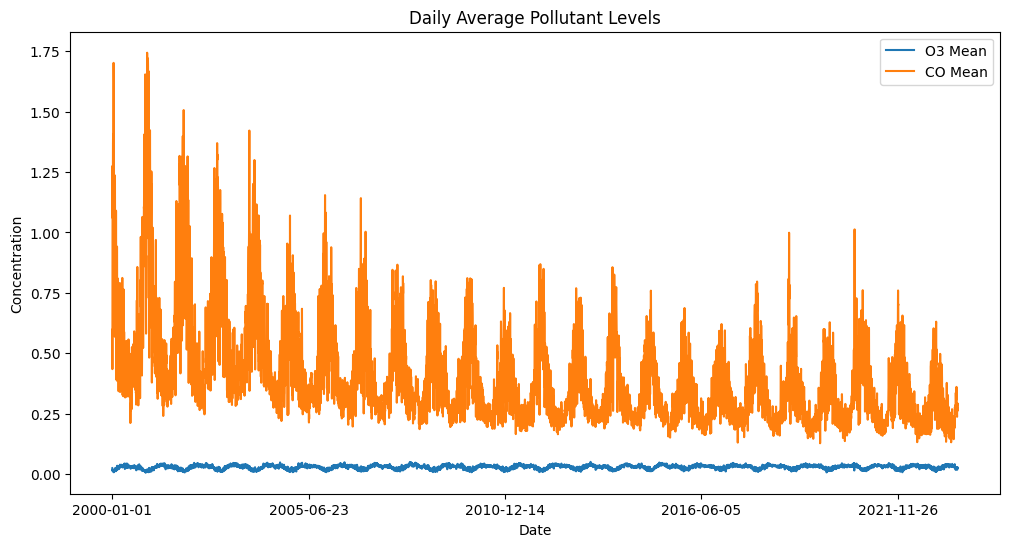

<function matplotlib.pyplot.show(close=None, block=None)>

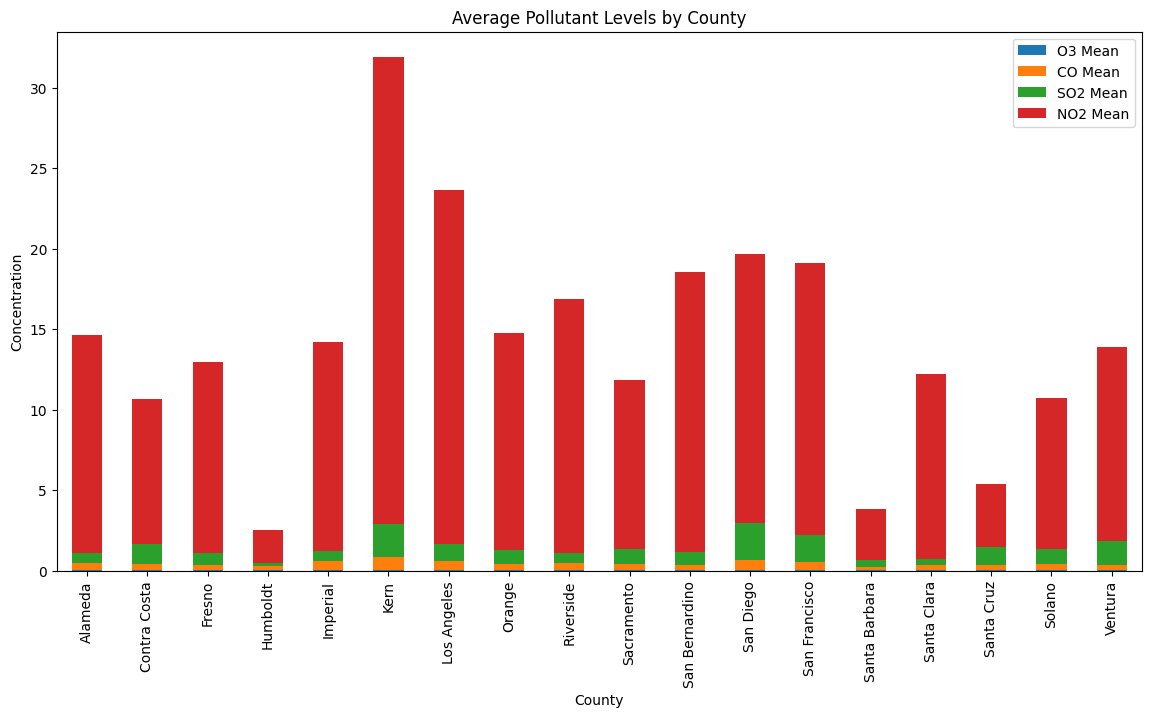

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Line plot for trends
data.groupby('Date')[['O3 Mean', 'CO Mean']].mean().plot(figsize=(12, 6))
plt.title('Daily Average Pollutant Levels')
plt.ylabel('Concentration')
plt.show()

# Stacked bar chart for county-wise averages
county_avg = data.groupby('County')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()
county_avg.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Average Pollutant Levels by County')
plt.ylabel('Concentration')
plt.show


In [10]:
# Extract date features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Compute the maximum AQI across all pollutants
aqi_columns = ['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']
data['Max AQI'] = data[aqi_columns].max(axis=1)

# Create a 'Pollution_Severity' column based on Max AQI
def categorize_aqi(max_aqi):
    if max_aqi <= 50:
        return 'Low'
    elif 51 <= max_aqi <= 100:
        return 'Moderate'
    elif 101 <= max_aqi <= 150:
        return 'High'
    else:
        return 'Very High'

data['Pollution_Severity'] = data['Max AQI'].apply(categorize_aqi)

# Drop redundant and less relevant columns
columns_to_drop = ['Unnamed: 0', 'State', 'Address', 'City', 'County',
                   'O3 1st Max Hour', 'CO 1st Max Hour', 'SO2 1st Max Hour', 'NO2 1st Max Hour']
data = data.drop(columns=columns_to_drop, axis=1)

# One-hot encode the 'City' and 'County' columns if needed
# data = pd.get_dummies(data, columns=['City', 'County'])

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(['Pollution_Severity'], axis=1)
y = data['Pollution_Severity']

X_train, X_test, y_train, y_test = train_test_split(                    #80-20%
    X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Check the data types of your features
print(X_train.dtypes)

# Drop or convert non-numeric columns
if 'Date' in X_train.columns:
    X_train = X_train.drop('Date', axis=1)
    X_test = X_test.drop('Date', axis=1)

# Ensure all columns are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Re-run the model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


# Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Date                 datetime64[ns]
O3 Mean                     float64
O3 1st Max Value            float64
O3 AQI                        int64
CO Mean                     float64
CO 1st Max Value            float64
CO AQI                      float64
SO2 Mean                    float64
SO2 1st Max Value           float64
SO2 AQI                     float64
NO2 Mean                    float64
NO2 1st Max Value           float64
NO2 AQI                       int64
Year                          int32
Month                         int32
Day                           int32
Max AQI                     float64
dtype: object


Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      1258
         Low       1.00      1.00      1.00     33140
    Moderate       1.00      1.00      1.00      5507
   Very High       1.00      0.99      1.00       344

    accuracy                           1.00     40249
   macro avg       1.00      1.00      1.00     40249
weighted avg       1.00      1.00      1.00     40249



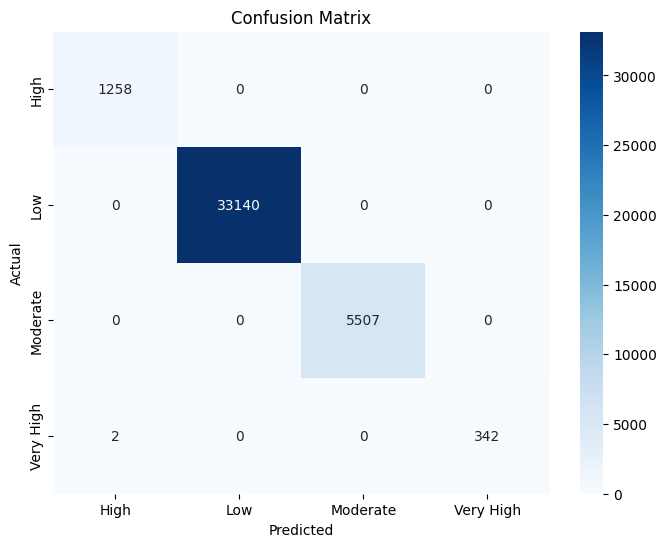

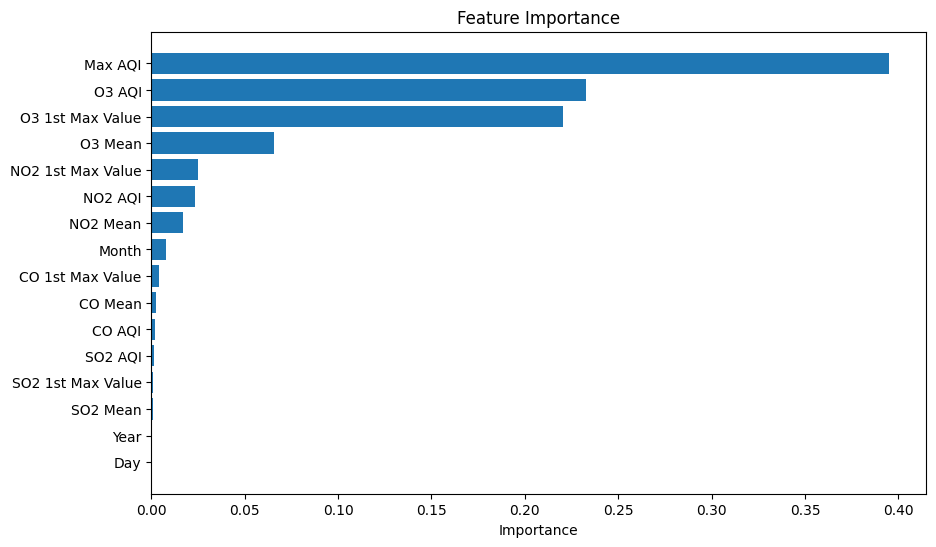

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance (for Random Forest)
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

#  ROC Curve for binary classification
if len(rf.classes_) == 2:  # Only if binary classification
    y_probs = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
